In [1]:
!pip install transformers
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import transformers
import json
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import logging
logging.basicConfig(level=logging.ERROR)


In [2]:
import torch
from tqdm.notebook import tqdm
!pip install transformers
from transformers import BertTokenizer
from torch.utils.data import TensorDataset
from transformers import BertForSequenceClassification
!pip install numba & conda install cudatoolkit

/bin/bash: line 1: conda: command not found


In [3]:
import numpy as np
import pandas as pd
import re
import nltk
from nltk.stem import PorterStemmer # for stemming
from nltk.stem import WordNetLemmatizer # for lemmatization
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
!pip install catboost

from catboost import CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.model_selection import train_test_split , cross_val_score,KFold
from collections import Counter
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import metrics
import warnings
!pip install imblearn
import imblearn
warnings.filterwarnings("ignore")

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.4 MB/s eta 0:00:00


In [4]:
# Setting up the device for GPU usage

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [5]:
#%%---------Data Read & Transformation---------

#Data Reading for Davidson Dataset
nRowsRead = None # specify 'None' to read complete file
data = pd.read_csv('Train-Augmentation.csv', delimiter=',', nrows = nRowsRead,encoding = "ISO-8859-1")
nRow, nCol = data.shape
print('There are {} rows and {} columns'.format(nRow, nCol))


There are 8577 rows and 2 columns


In [6]:
data.shape
data.head(100)

,label,tweet
0,1,RT @CurlsGoddess: Being so wrapped up in love ...
1,1,Don't blame me blame ya bitch can't help she w...
2,1,@LoVeZanda so everybody knw I mis-spell shit &...
3,1,&#128128;&#128128; RT @monique504Q: &#128557;&...
4,1,@jay_ibarra95 too bad bitch! You in this shit ...
...,...,...
95,1,"RT @chvmpagne: fat bitch: ""I'm thick"" http://t..."
96,1,@cristiannt_ bitch I back shit up fuck nigga
97,1,Can Dick Sherman get caught doing blow of a tr...
98,1,@RealWallieWall Ms. Martinez fuckin with the c...


In [7]:
data['label'].unique()

array([1, 2, 0])

In [8]:
data.describe()

,label
count,8577.000000
mean,1.000000
std,0.816544
min,0.000000
25%,0.000000
50%,1.000000
75%,2.000000
max,2.000000


In [9]:
new_df = data[['label', 'tweet']]
new_df.head()

,label,tweet
0,1,RT @CurlsGoddess: Being so wrapped up in love ...
1,1,Don't blame me blame ya bitch can't help she w...
2,1,@LoVeZanda so everybody knw I mis-spell shit &...
3,1,&#128128;&#128128; RT @monique504Q: &#128557;&...
4,1,@jay_ibarra95 too bad bitch! You in this shit ...


In [10]:
from sklearn.metrics import precision_score,recall_score,accuracy_score, f1_score
def show_confusion(pred_label,label,nm):
  class_names=['Hate','Ofensive','Neither']
  cm=confusion_matrix(label,pred_label)
  disp =ConfusionMatrixDisplay(cm,display_labels=class_names)
  disp.plot()
  plt.title(f'Confusion Matrix {nm}')
  plt.xlabel('Actual')
  plt.ylabel('Predicted')
  plt.show()

def mymetrics(Y,P , alg = None):
    recall= recall_score(Y, P)
    acc2= accuracy_score(Y, P)
    precision= precision_score(Y, P)
    Fmeasure = f1_score(Y, P)
    print(f"accuracy = {acc2*100}")
    print(f'recall= {recall*100}')
    print(f'precision= {precision*100}')
    print(f'Fmeasure= {Fmeasure*100}')

In [11]:
from transformers import BertModel, BertTokenizer


In [12]:
# Defining some key variables that will be used later on in the training
MAX_LEN = 256
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 4
# EPOCHS = 1
LEARNING_RATE = 1e-05
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', truncation=True, do_lower_case=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [13]:
class SentimentData(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.tweet
        self.targets = self.data.label
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [14]:
# خواندن داده‌ها از فایل CSV
valid_data = pd.read_csv('Validation.csv', delimiter=',', encoding="ISO-8859-1")

# تعداد ردیف‌ها و ستون‌های داده‌ها
nTrainRow, nTrainCol = new_df.shape
nValidRow, nValidCol = valid_data.shape
print(f'Training Data: {nTrainRow} rows and {nTrainCol} columns')
print(f'Validation Data: {nValidRow} rows and {nValidCol} columns')

# ایجاد دیتاست‌های SentimentData برای داده‌های آموزشی و اعتبارسنجی
training_set = SentimentData(new_df, tokenizer, MAX_LEN)
validation_set = SentimentData(valid_data, tokenizer, MAX_LEN)

# چاپ اطلاعات مجموعه داده‌ها برای بررسی
print(f"TRAIN Dataset: {len(training_set)} samples")
print(f"VALIDATION Dataset: {len(validation_set)} samples")


Training Data: 8577 rows and 2 columns
Validation Data: 2974 rows and 2 columns
TRAIN Dataset: 8577 samples
VALIDATION Dataset: 2974 samples


In [15]:
#train_size = 0.85
#train_data=new_df.sample(frac=train_size,random_state=200)
#validation_data=new_df.drop(train_data.index).reset_index(drop=True)
#train_data = train_data.reset_index(drop=True)

#print("FULL Dataset: {}".format(new_df.shape))
#print("TRAIN Dataset: {}".format(train_data.shape))
#print("validation Dataset: {}".format(validation_data.shape))
##training_set = SentimentData(train_data, tokenizer, MAX_LEN)
#testing_set = SentimentData(validation_data, tokenizer, MAX_LEN)

In [16]:
train_params = {
    'batch_size': TRAIN_BATCH_SIZE,
    'shuffle': True,
    'num_workers': 0
}

test_params = {
    'batch_size': VALID_BATCH_SIZE,
    'shuffle': False,
    'num_workers': 0
}

# ایجاد DataLoader ها
training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(validation_set, **test_params)


In [18]:
#train_params = {'batch_size': TRAIN_BATCH_SIZE,
 #               'shuffle': True,
 #               'num_workers': 0
     #            }

#test_params = {'batch_size': VALID_BATCH_SIZE,
#                'shuffle': False,
#                'num_workers': 0
    #               }

#training_loader = DataLoader(training_set, **train_params)
#testing_loader = DataLoader(testing_set, **test_params)

In [19]:
class BertClass(torch.nn.Module):
    def __init__(self):
        super(BertClass, self).__init__()
        self.l1 = BertModel.from_pretrained("bert-base-uncased")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, 5)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

In [20]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [22]:
model = BertClass()
model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BertClass(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affin

In [23]:
# Creating the loss function and optimizer
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

In [24]:
def calcuate_accuracy(preds, targets):
    n_correct = (preds==targets).sum().item()
    return n_correct

In [25]:
# Defining the training function on the 80% of the dataset for tuning the distilbert model

def train(epoch):
    tr_loss = 0
    n_correct = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    model.train()
    for _,data in tqdm(enumerate(training_loader, 0)):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)

        outputs = model(ids, mask, token_type_ids)
        loss = loss_function(outputs, targets)
        tr_loss += loss.item()
        big_val, big_idx = torch.max(outputs.data, dim=1)
        n_correct += calcuate_accuracy(big_idx, targets)

        nb_tr_steps += 1
        nb_tr_examples+=targets.size(0)

        if _%5000==0:
            loss_step = tr_loss/nb_tr_steps
            accu_step = (n_correct*100)/nb_tr_examples
            print(f"Training Loss per 5000 steps: {loss_step}")
            print(f"Training Accuracy per 5000 steps: {accu_step}")

        optimizer.zero_grad()
        loss.backward()
        # # When using GPU
        optimizer.step()

    print(f'The Total Accuracy for Epoch {epoch}: {(n_correct*100)/nb_tr_examples}')
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Training Loss Epoch: {epoch_loss}")
    print(f"Training Accuracy Epoch: {epoch_accu}")


    return

In [26]:
EPOCHS = 10
for epoch in range(EPOCHS):
    train(epoch)

0it [00:00, ?it/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Training Loss per 5000 steps: 1.6533937454223633
Training Accuracy per 5000 steps: 25.0
The Total Accuracy for Epoch 0: 84.71493529206016
Training Loss Epoch: 0.4349693344890349
Training Accuracy Epoch: 84.71493529206016


0it [00:00, ?it/s]

Training Loss per 5000 steps: 0.7231251001358032
Training Accuracy per 5000 steps: 75.0
The Total Accuracy for Epoch 1: 91.10411565815554
Training Loss Epoch: 0.25332845586898
Training Accuracy Epoch: 91.10411565815554


0it [00:00, ?it/s]

Training Loss per 5000 steps: 0.03224528953433037
Training Accuracy per 5000 steps: 100.0
The Total Accuracy for Epoch 2: 93.34266060394077
Training Loss Epoch: 0.1890602181695978
Training Accuracy Epoch: 93.34266060394077


0it [00:00, ?it/s]

Training Loss per 5000 steps: 0.15006695687770844
Training Accuracy per 5000 steps: 100.0
The Total Accuracy for Epoch 3: 95.26641016672497
Training Loss Epoch: 0.1308939029334177
Training Accuracy Epoch: 95.26641016672497


0it [00:00, ?it/s]

Training Loss per 5000 steps: 0.09617451578378677
Training Accuracy per 5000 steps: 100.0
The Total Accuracy for Epoch 4: 97.13186428821267
Training Loss Epoch: 0.07972881174564947
Training Accuracy Epoch: 97.13186428821267


0it [00:00, ?it/s]

Training Loss per 5000 steps: 0.010913345031440258
Training Accuracy per 5000 steps: 100.0
The Total Accuracy for Epoch 5: 98.47265943803194
Training Loss Epoch: 0.04662001493803763
Training Accuracy Epoch: 98.47265943803194


0it [00:00, ?it/s]

Training Loss per 5000 steps: 0.0023850402794778347
Training Accuracy per 5000 steps: 100.0
The Total Accuracy for Epoch 6: 98.91570479188528
Training Loss Epoch: 0.031945991716308575
Training Accuracy Epoch: 98.91570479188528


0it [00:00, ?it/s]

Training Loss per 5000 steps: 0.0033611145336180925
Training Accuracy per 5000 steps: 100.0
The Total Accuracy for Epoch 7: 99.4287046752944
Training Loss Epoch: 0.018094312744965917
Training Accuracy Epoch: 99.4287046752944


0it [00:00, ?it/s]

Training Loss per 5000 steps: 0.000856049417052418
Training Accuracy per 5000 steps: 100.0
The Total Accuracy for Epoch 8: 99.3820683222572
Training Loss Epoch: 0.017775910247195614
Training Accuracy Epoch: 99.3820683222572


0it [00:00, ?it/s]

Training Loss per 5000 steps: 0.05752536654472351
Training Accuracy per 5000 steps: 100.0
The Total Accuracy for Epoch 9: 99.58027282266526
Training Loss Epoch: 0.014732660465934643
Training Accuracy Epoch: 99.58027282266526


In [27]:
from sklearn.metrics import classification_report


In [28]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

def valid(model, testing_loader):
   # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0
  all_logits=[]
  all_labels=[]
  # Evaluate data for one epoch
  for _,data in tqdm(enumerate(testing_loader, 0)):
    ids = data['ids'].to(device, dtype = torch.long)
    mask = data['mask'].to(device, dtype = torch.long)
    token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
    targets = data['targets'].to(device, dtype = torch.long)


    with torch.no_grad():
      # Forward pass, calculate logit predictions
      output = model(ids, mask, token_type_ids)
      logits = output

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = targets.to('cpu').numpy()
    all_logits.extend(np.argmax(logits, axis=1).flatten())
    all_labels.extend(label_ids)
  accuracy = accuracy_score(all_logits , all_labels)


  val_f1 = f1_score(all_logits, all_labels, average='macro')
  val_precision = precision_score(all_logits, all_labels, average='macro')
  val_recall = recall_score(all_logits, all_labels, average='macro')

  show_confusion(all_labels,all_logits,' BERT')

  c = classification_report(all_labels, all_logits, digits=4)
  print(c)


*****validation acuracy*******


0it [00:00, ?it/s]

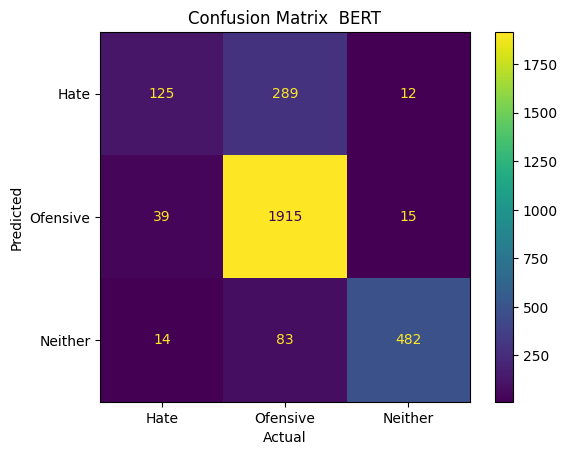

              precision    recall  f1-score   support

           0     0.2934    0.7022    0.4139       178
           1     0.9726    0.8373    0.8999      2287
           2     0.8325    0.9470    0.8860       509

    accuracy                         0.8480      2974
   macro avg     0.6995    0.8288    0.7333      2974
weighted avg     0.9079    0.8480    0.8684      2974



In [29]:
print("*****validation acuracy*******")
valid(model, testing_loader)

In [30]:
#%%---------Data Read & Transformation---------

#Data Reading for Davidson Dataset
nRowsRead = None # specify 'None' to read complete file
df0 = pd.read_csv('Test.csv', delimiter=',', nrows = nRowsRead,encoding = "ISO-8859-1")
nRow, nCol = df0.shape
print('There are {} rows and {} columns'.format(nRow, nCol))


There are 4957 rows and 2 columns


In [31]:
test_data2 = df0[['label', 'tweet']]
test_data2.head()

,label,tweet
0,2,RT @paulabruederle: Some birds aren't meant to...
1,1,RT @paullowry42: @gingerash2013 lol and your r...
2,1,RT @paymon_d: Legendary year. RT @1stName_Brav...
3,1,RT @peaceloveweed_: These hoes want my belvita...
4,2,"RT @peeabut: Dear god, make me a bird so I can..."


*****test acuracy*******


0it [00:00, ?it/s]

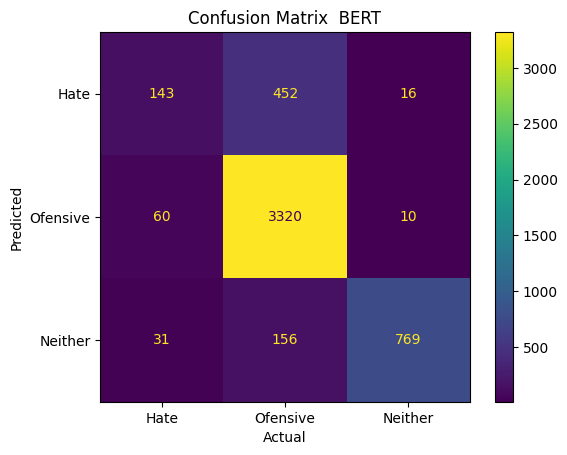

              precision    recall  f1-score   support

           0     0.2340    0.6111    0.3385       234
           1     0.9794    0.8452    0.9074      3928
           2     0.8044    0.9673    0.8784       795

    accuracy                         0.8537      4957
   macro avg     0.6726    0.8079    0.7081      4957
weighted avg     0.9161    0.8537    0.8758      4957



In [32]:
testing_set2 = SentimentData(test_data2, tokenizer, MAX_LEN)
testing_loader2 = DataLoader(testing_set2, **test_params)


print("*****test acuracy*******")
valid(model, testing_loader2)

In [33]:
import pandas as pd
import numpy as np
import torch
from tqdm import tqdm

# تابع برای پیش‌بینی با مدل RoBERTa
def predict_with_roberta(test_loader, texts):
    model.eval()
    all_logits = []
    all_labels = []
    all_texts = []
    idx = 0
    for _, data in tqdm(enumerate(test_loader, 0)):
        ids = data['ids'].to(device, dtype=torch.long)
        mask = data['mask'].to(device, dtype=torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
        targets = data['targets'].to(device, dtype=torch.long)

        with torch.no_grad():
            outputs = model(ids, mask, token_type_ids)
            logits = outputs.detach().cpu().numpy()
            all_logits.extend(np.argmax(logits, axis=1).flatten())
            all_labels.extend(targets.cpu().numpy())
            all_texts.extend(texts[idx:idx + len(targets)])  # اضافه کردن متن توییت‌ها
            idx += len(targets)

    return all_labels, all_logits, all_texts

# تابع برای ذخیره‌سازی پیش‌بینی‌ها به همراه متن توییت‌ها
def save_predictions_with_text(dataframe, predictions, filename):
    dataframe['predictions'] = predictions
    dataframe.to_csv(filename, index=False)

# پیش‌بینی‌ها را دریافت کنید
test_data2 = pd.read_csv('Test.csv', delimiter=',', encoding="ISO-8859-1")
test_data2 = test_data2[['label', 'tweet']]
test_texts = test_data2['tweet'].tolist()  # تبدیل به لیست برای استفاده در تابع پیش‌بینی

test_labels, test_preds, test_texts = predict_with_roberta(testing_loader2, test_texts)

# اضافه کردن پیش‌بینی‌ها به دیتافریم
test_data2['predictions'] = test_preds

# ذخیره‌سازی پیش‌بینی‌ها به همراه متن توییت‌ها
test_data2.to_csv('bert_predictions_with_text.csv', index=False)

print("پیش‌بینی‌ها با موفقیت ذخیره شد.")


1240it [01:16, 16.14it/s]

پیش‌بینی‌ها با موفقیت ذخیره شد.
